In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, random
from tqdm import tqdm
from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
from transformers import Dinov2Model

device = torch.device('mps')

from src.train_functions import train_epoch_threehead, validate_epoch_threehead
from src.preprocess_data import data_preprocess, BiomassDS
from src.models import get_dino, get_three_head_dino


/opt/miniconda3/envs/pytorch_csiro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# project_dir     = '/Users/k.choi/Documents/github/csiro_git'
project_dir     = '/Users/kaheichoi/git_repo/csiro_biomass'
data_dir        = os.path.join(project_dir, 'data')
model_dir       = os.path.join(project_dir, 'models'); os.makedirs(model_dir, exist_ok=True)

csv_data        = pd.read_csv(os.path.join(data_dir, 'train.csv'))
target_names    = csv_data['target_name'].unique()
primary_target  = ['Dry_Green_g','Dry_Total_g','GDM_g']

In [3]:
data = data_preprocess(csv_data, data_dir)

# train_data, test_data = train_test_split(data, test_size=0.05, random_state=8964)
train_data, valid_data  = train_test_split(data, test_size=0.2, random_state=8964)

print(f"train data: {len(train_data)}")
print(f"valid data: {len(valid_data)}")
# print(f"test data: {len(test_data)}")


train data: 285
valid data: 72


In [4]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

batch_size = 16 
WORKERS = 0

# class rand_rota:
#     def __call__(self, img):
#         angle = np.random.choice([0,90,180,270])
#         return transforms.functional.rotate(img, int(angle))

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # rand_rota(),
    transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), transforms.Normalize(mean=mean, std=std) ])

train_ds = BiomassDS(df =train_data, data_dir=data_dir, transform=train_transform, target_names=primary_target)
valid_ds = BiomassDS(df =valid_data, data_dir=data_dir, transform=valid_transform, target_names=primary_target)
# test_ds  = BiomassDS(df =test_data,  data_dir=data_dir, transform=valid_transform, target_names=primary_target)
assert len(train_ds) == len(train_data) and len(valid_ds) == len(valid_data)

train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=WORKERS, shuffle=True  , pin_memory=False)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, num_workers=WORKERS, shuffle=False , pin_memory=False)
# test_loader  = DataLoader(test_ds,  batch_size=batch_size, num_workers=WORKERS, shuffle=False , pin_memory=False)

In [5]:
"""Select dinov2 model"""
dinov2 = Dinov2Model.from_pretrained('facebook/dinov2-small'); patch_dim = 384; model_name = 'dinov2_small_three_heads'
# dinov2 = Dinov2Model.from_pretrained('facebook/dinov2-base'); patch_dim = 768; model_name = 'dinov2_base'
# dinov2 = Dinov2Model.from_pretrained('facebook/dinov2-large'); patch_dim = 1024; model_name = 'dinov2_large'
dinov2.eval(); dinov2.to(device);
model = get_three_head_dino(dinov2, patch_dim=patch_dim, num_targets=3); model.to(device);

In [ ]:

all_params = sum(p.numel() for p in model.parameters()); print(f"Total parameters: {all_params}")
train_params = sum(p.numel() for p in model.heads.parameters());print(f"Trainable parameters: {train_params}")
frozen_params = sum(p.numel() for p in model.backbone.parameters());print(f"Frozen parameters: {frozen_params}")

In [6]:
LR = 1e-3 
WEIGHT_DECAY = 1e-4 
EARLY_STOPPING_PATIENCE = 10
LR_PATIENCE = 5
LR_FACTOR = 0.5

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience= LR_PATIENCE)
criterion = nn.MSELoss()

In [7]:
NUM_EPOCHS = 100

epoch_counts = 0
best_val = float('inf')
best_model = None

history = {'train_loss': [], 'valid_loss': [], 'val_rmse': [], 'pre_target_rmse': [], 'learning_rate': []}
for epoch in range(NUM_EPOCHS):

    train_loss                              = train_epoch_threehead(model, train_loader, optimizer, criterion, device)
    valid_loss, rmse, all_preds, all_targs  = validate_epoch_threehead(model, valid_loader, criterion, device)

    scheduler.step(valid_loss)
    current_lr = optimizer.param_groups[0]['lr']

    per_target_rmse = np.sqrt(np.mean((all_preds - all_targs)**2, axis=0))
    
    """ update history """
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['val_rmse'].append(rmse)
    history['learning_rate'].append(current_lr)
    history['pre_target_rmse'].append(per_target_rmse) 

    print(f"\nEpoch: {epoch}/{NUM_EPOCHS}"); print(32 * " -")
    print(f"  train loss: {train_loss:.1f}")
    print(f"  valid loss: {valid_loss:.1f}")
    print(f"  rmse: {rmse:.1f}") 
    print(f"  lr: {current_lr:.6f}")
    print(f"  per target rmse: {per_target_rmse}")

    if valid_loss < best_val:
        print(f"val_loss improved from {best_val:.4f} to {valid_loss:.4f}")
        best_val = valid_loss
        epoch_counter = 0
        torch.save(model.state_dict(), os.path.join(model_dir, f'best_model_{model_name}.pth'))
        best_model = model.state_dict()
        print(f"best model saved")

    else:
        epoch_counter += 1
        print(f"no val_loss improvement from {best_val:.4f}")

    
    if epoch_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break

Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s, loss=2.54e+3]



Epoch: 0/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 5421.0
  valid loss: 3757.8
  rmse: 36.0
  lr: 0.001000
  per target rmse: [28.657713 46.254044 30.537743]
val_loss improved from inf to 3757.7700
best model saved


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s, loss=1.23e+3]



Epoch: 1/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 3826.9
  valid loss: 2231.8
  rmse: 27.9
  lr: 0.001000
  per target rmse: [22.429987 36.454636 22.595076]
val_loss improved from 3757.7700 to 2231.8191
best model saved


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s, loss=878]    



Epoch: 2/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 2591.0
  valid loss: 1607.6
  rmse: 23.7
  lr: 0.001000
  per target rmse: [21.675076 27.608053 21.368612]
val_loss improved from 2231.8191 to 1607.5787
best model saved


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s, loss=258]    



Epoch: 3/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 2015.5
  valid loss: 1053.7
  rmse: 19.5
  lr: 0.001000
  per target rmse: [17.791832 23.166899 16.997173]
val_loss improved from 1607.5787 to 1053.7285
best model saved


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s, loss=250]    



Epoch: 4/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 1453.6
  valid loss: 824.4
  rmse: 17.2
  lr: 0.001000
  per target rmse: [15.77508  20.015059 15.451146]
val_loss improved from 1053.7285 to 824.4226
best model saved


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s, loss=251]    



Epoch: 5/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 1169.5
  valid loss: 652.7
  rmse: 15.2
  lr: 0.001000
  per target rmse: [13.260311 18.841946 12.903155]
val_loss improved from 824.4226 to 652.7412
best model saved


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s, loss=163]



Epoch: 6/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 992.4
  valid loss: 528.5
  rmse: 13.8
  lr: 0.001000
  per target rmse: [11.637823 17.366335 11.492969]
val_loss improved from 652.7412 to 528.5301
best model saved


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s, loss=256]



Epoch: 7/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 826.2
  valid loss: 522.4
  rmse: 13.6
  lr: 0.001000
  per target rmse: [12.048576  17.32456   10.3281555]
val_loss improved from 528.5301 to 522.3661
best model saved


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s, loss=128]



Epoch: 8/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 790.8
  valid loss: 429.2
  rmse: 12.4
  lr: 0.001000
  per target rmse: [ 9.892678 16.659513  9.341037]
val_loss improved from 522.3661 to 429.1566
best model saved


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s, loss=194]



Epoch: 9/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 759.4
  valid loss: 461.5
  rmse: 12.8
  lr: 0.001000
  per target rmse: [10.027526 16.084528 11.488861]
no val_loss improvement from 429.1566


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s, loss=316]    



Epoch: 10/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 692.5
  valid loss: 624.8
  rmse: 14.8
  lr: 0.001000
  per target rmse: [13.101138 19.023664 11.20921 ]
no val_loss improvement from 429.1566


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s, loss=180]



Epoch: 11/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 630.2
  valid loss: 461.7
  rmse: 12.8
  lr: 0.001000
  per target rmse: [10.048519 16.33541  11.19273 ]
no val_loss improvement from 429.1566


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s, loss=201]



Epoch: 12/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 579.7
  valid loss: 471.1
  rmse: 12.9
  lr: 0.001000
  per target rmse: [10.700572 17.188513  9.548446]
no val_loss improvement from 429.1566


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s, loss=205]



Epoch: 13/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 511.0
  valid loss: 444.1
  rmse: 12.5
  lr: 0.001000
  per target rmse: [10.446414 16.071152 10.162685]
no val_loss improvement from 429.1566


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s, loss=165]



Epoch: 14/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 497.7
  valid loss: 426.0
  rmse: 12.3
  lr: 0.001000
  per target rmse: [10.10855  16.235928  9.44771 ]
val_loss improved from 429.1566 to 426.0296
best model saved


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s, loss=148]



Epoch: 15/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 492.7
  valid loss: 429.8
  rmse: 12.4
  lr: 0.001000
  per target rmse: [10.6258955 16.237604   9.197928 ]
no val_loss improvement from 426.0296


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s, loss=132]



Epoch: 16/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 490.7
  valid loss: 439.4
  rmse: 12.6
  lr: 0.001000
  per target rmse: [10.026438 16.73481   9.63707 ]
no val_loss improvement from 426.0296


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s, loss=216]



Epoch: 17/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 409.7
  valid loss: 491.9
  rmse: 13.2
  lr: 0.001000
  per target rmse: [10.951469 17.913408  9.039921]
no val_loss improvement from 426.0296


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s, loss=193]    



Epoch: 18/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 381.8
  valid loss: 527.2
  rmse: 13.7
  lr: 0.001000
  per target rmse: [11.242005 18.3482   10.063979]
no val_loss improvement from 426.0296


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s, loss=179]



Epoch: 19/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 392.7
  valid loss: 505.4
  rmse: 13.4
  lr: 0.001000
  per target rmse: [10.721611 17.78042  10.513166]
no val_loss improvement from 426.0296


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s, loss=184]



Epoch: 20/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 363.4
  valid loss: 512.2
  rmse: 13.5
  lr: 0.000500
  per target rmse: [11.353907 18.058191  9.673247]
no val_loss improvement from 426.0296


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s, loss=233]



Epoch: 21/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 346.1
  valid loss: 514.2
  rmse: 13.5
  lr: 0.000500
  per target rmse: [11.326485 17.839561  9.945444]
no val_loss improvement from 426.0296


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s, loss=187]



Epoch: 22/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 322.8
  valid loss: 482.8
  rmse: 13.1
  lr: 0.000500
  per target rmse: [10.864656 17.438602  9.67056 ]
no val_loss improvement from 426.0296


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s, loss=132]



Epoch: 23/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 278.8
  valid loss: 452.9
  rmse: 12.8
  lr: 0.000500
  per target rmse: [10.404019 17.035746  9.489312]
no val_loss improvement from 426.0296


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s, loss=139]


Epoch: 24/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 301.3
  valid loss: 455.9
  rmse: 12.8
  lr: 0.000500
  per target rmse: [10.248516 17.227814  9.447166]
no val_loss improvement from 426.0296
Early stopping at epoch 25


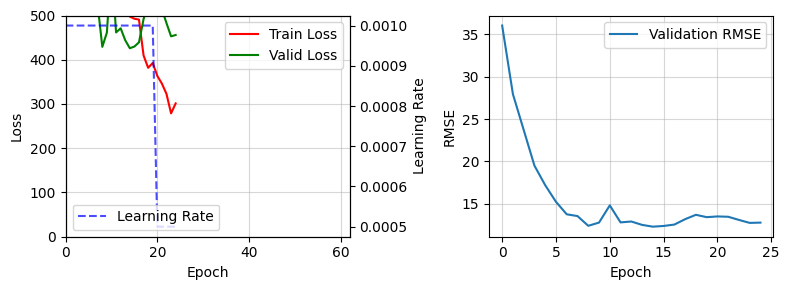

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes = axes.flatten()

axes[0].plot(history['train_loss'], label='Train Loss', c='r')
axes[0].plot(history['valid_loss'], label='Valid Loss', c='g')
axes[0].legend(loc = 'upper right')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_xlim(0, 62)
axes[0].set_ylim(0, 500)

ax1 = axes[0].twinx()
ax1.plot(history['learning_rate'], label='Learning Rate', c='b', ls='--', alpha=0.7)
ax1.set_ylabel('Learning Rate')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower left')

axes[1].plot(history['val_rmse'], label='Validation RMSE')
axes[1].legend(loc='upper right')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Epoch')
axes[0].grid(True,alpha=0.5)
axes[1].grid(True,alpha=0.5)

plt.tight_layout()
plt.show()


In [9]:
data.describe()

,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
count,357.000000,357.000000,357.000000,357.000000,357.000000
mean,6.649692,12.044548,26.624722,45.318097,33.274414
std,12.117761,12.402007,25.401232,27.984015,24.935822
min,0.000000,0.000000,0.000000,1.040000,1.040000
25%,0.000000,3.200000,8.800000,25.271500,16.026100
50%,1.423500,7.980900,20.800000,40.300000,27.108200
75%,7.242900,17.637800,35.083400,57.880000,43.675700
max,71.786500,83.840700,157.983600,185.700000,157.983600


In [16]:
history_pd = pd.DataFrame(history)
history_pd.to_csv(os.path.join(model_dir, f'history_{model_name}.csv'), index=False)

In [17]:
def get_all_targets(pred_green, pred_total, pred_gdm):
    pred_green = torch.clamp(pred_green, min=0)
    pred_clover = torch.clamp(pred_gdm - pred_green, min=0)
    pred_dead = torch.clamp(pred_total - pred_gdm, min=0)
    return torch.stack([pred_clover, pred_dead, pred_green, pred_total, pred_gdm], dim=1).squeeze(-1)

In [27]:
def eval_testds_three(model, loader, device):  

    pred_list , targ_list = [], []
    with torch.no_grad():
        pbar = tqdm(loader, desc='Testing')
        for img, tar in pbar:
            img = img.to(device); tar = tar.to(device)
            pred_green, pred_total, pred_gdm = model(img)
            tar_green, tar_total, tar_gdm = tar[:,0], tar[:,1], tar[:,2]
            
            pred_list.append( torch.stack([pred_green, pred_total, pred_gdm], dim=1).cpu() )
            targ_list.append( torch.stack([tar_green, tar_total, tar_gdm], dim=1).cpu() )

        pred_list = torch.cat(pred_list, dim=0).numpy()
        targ_list = torch.cat(targ_list, dim=0).numpy()
    return pred_list, targ_list


In [28]:
def eval_testds(model, loader, device):  

    pred_list , targ_list = [], []
    with torch.no_grad():
        pbar = tqdm(loader, desc='Testing')
        for img, tar in pbar:
            img = img.to(device); tar = tar.to(device)
            pred_green, pred_total, pred_gdm = model(img)
            tar_green, tar_total, tar_gdm = tar[:,0], tar[:,1], tar[:,2]
            
            pred_list.append(get_all_targets(pred_green, pred_total, pred_gdm).cpu())
            targ_list.append(get_all_targets(tar_green, tar_total, tar_gdm).cpu())

        pred_list = torch.cat(pred_list, dim=0).numpy()
        targ_list = torch.cat(targ_list, dim=0).numpy()
    return pred_list, targ_list

    

model.load_state_dict(torch.load(os.path.join(model_dir, f'best_model_{model_name}.pth')))
model.eval();

pred_list, targ_list = eval_testds_three(model, valid_loader, device)

# for i in range(len(valid_data)):
#     display( pd.DataFrame( { 'predicted': pred_list[i,:], 'target': targ_list[i,:] } ) )
    

Testing: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


In [30]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

metric_data = []

for i , tar in enumerate(primary_target):
    y_true, y_pred = targ_list[:,i], pred_list[:,i]
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    metric_data.append({ 'target': tar, 'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2})

metric_data.append({
    'target' : 'overall', 
    'mae': mean_absolute_error(targ_list.flatten(), pred_list.flatten()), 
    'mse': mean_squared_error(targ_list.flatten(), pred_list.flatten()), 
    'rmse': np.sqrt(mean_squared_error(targ_list.flatten(), pred_list.flatten())), 
    'r2': r2_score(targ_list.flatten(), pred_list.flatten())})

metric_df = pd.DataFrame(metric_data)
display(metric_df)
metric_df.to_csv(os.path.join(model_dir, f'metric_{model_name}.csv'), index=False)

,target,mae,mse,rmse,r2
0,Dry_Green_g,7.708766,102.182793,10.108550,0.778899
1,Dry_Total_g,11.502053,263.605347,16.235928,0.625187
2,GDM_g,7.375392,89.259239,9.447711,0.797706
3,overall,8.862071,151.682449,12.315943,0.750333


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

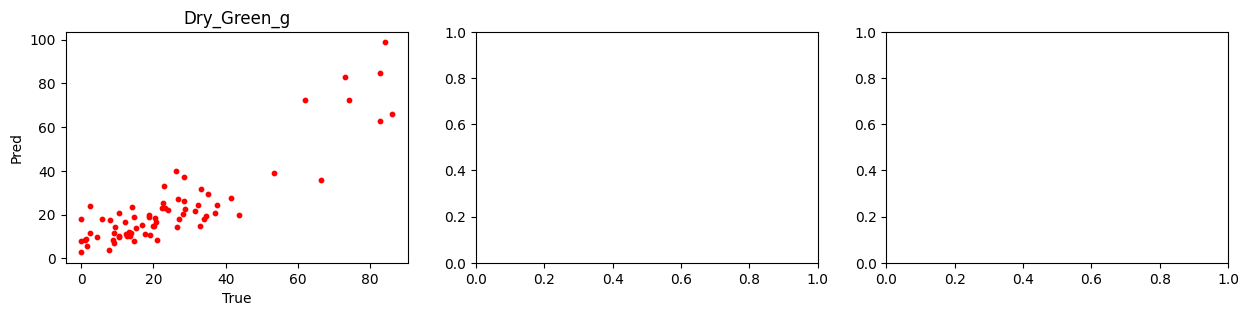

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

for i , tar in enumerate(primary_target):
    y_true, y_pred = targ_list[:,i], pred_list[:,i]
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    axes[i].scatter(y_true, y_pred, alpha=1, c='r', s= 10)
    if i>0: axes[i].sharey(axes[0]);
    else : axes[i].set_ylabel('Pred')
    axes[i].set_xlabel('True')
    axes[i].set_title(f'{tar}')
    axes[i].plot([min_val, max_val], [min_val, max_val], c='k', lw=2, label = 'prefect')
    axes[i].legend(loc = 'lower right', fontsize = 9)
plt.tight_layout(); plt.show()

In [ ]:
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# for i in range(len(primary_target)):

#     true_target = targ_list[:,i]
#     pred_target = pred_list[:,i]
#     # true_target = test_data[tar].values
#     # pred_target = all_test_preds[:, i]

#     mse = mean_squared_error(true_target, pred_target) 
#     rmse = np.sqrt(mse)
#     r2 = r2_score(true_target, pred_target)
#     mae = mean_absolute_error(true_target, pred_target)
#     print(f"-- target: {primary_target[i]}")
#     print(f" mean: {np.mean(true_target):.2f}")
#     print(f" rmse: {rmse:.2f}")
#     print(f" r2: {r2:.2f}")
#     print(f" mae: {mae:.2f}")